### Genome-wide perturb-seq

This notebook prepares a dataset from a [paper with giant Perturb-seq experiments](https://www.cell.com/cell/fulltext/S0092-8674(22)00597-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867422005979%3Fshowall%3Dtrue) applied to all expressed genes or all essential genes.

Here we tidy the dataset and carry out a simple exploration in scanpy.

We start from a pseudo-bulk version where all cells are added together within each perturbation. 

This dataset does knockdown, not knockout. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import regex as re
import os
import shutil
import importlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scipy.stats import spearmanr as spearmanr
from IPython.display import display, HTML
from collections import Counter

# local
import importlib
import sys
sys.path.append("setup")
import ingestion
importlib.reload(ingestion)

import anndata
import os, sys
import itertools as it
from scipy.stats import spearmanr, pearsonr, rankdata, f_oneway
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#      visualization settings
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# I prefer to specify the working directory explicitly.
os.chdir("/home/ekernf01/Desktop/jhu/research/projects/perturbation_prediction/cell_type_knowledge_transfer/perturbation_data")

# Universal
geneAnnotationPath = "../accessory_data/gencode.v35.annotation.gtf.gz"       # Downloaded from https://www.gencodegenes.org/human/release_35.html
humanTFPath =  "../accessory_data/humanTFs.csv"                              # Downloaded from http://humantfs.ccbr.utoronto.ca/download.php
humanEpiPath = "../accessory_data/epiList.csv"                               # Downloaded from https://epifactors.autosome.org/description 
cellcycleGenePath = "../accessory_data/regev_lab_cell_cycle_genes.txt"

# Replogle3 Specific
dataset_name = "replogle3"
perturbEffectTFOnlyPath = "setup/replogle3TFOnly.csv"                         # a path to store temp file
perturbEffectFullTranscriptomePath = "setup/replogle3FullTranscriptome.csv"   # a path to store temp file

### Load expression data & set up cell metadata

In [2]:
expression_quantified = sc.read_h5ad(f"not_ready/{dataset_name}/K562_essential_raw_bulk_01.h5ad")
expression_quantified.var_names = ingestion.convert_ens_to_symbol(
    expression_quantified.var_names, 
    gtf=geneAnnotationPath,
    strip_version=True,
)
expression_quantified

AnnData object with n_obs × n_vars = 2285 × 8563
    obs: 'UMI_count_unfiltered', 'num_cells_unfiltered', 'num_cells_filtered', 'control_expr', 'fold_expr', 'pct_expr', 'core_control', 'mean_leverage_score', 'std_leverage_score', 'energy_test_p_value', 'anderson_darling_counts', 'mann_whitney_counts', 'z_gemgroup_UMI', 'mitopercent', 'TE_ratio', 'cnv_score_z'
    var: 'gene_name', 'mean', 'std', 'cv', 'in_matrix', 'gini', 'clean_mean', 'clean_std', 'clean_cv'

### Fill `perturbation` & `is_control` and find TF's

In [3]:
human_tfs = pd.read_csv(humanTFPath)
human_tfs = human_tfs.loc[human_tfs["Is TF?"]=="Yes",:]
expression_quantified.obs["gene_symbol"] = [s.split("_")[1] for s in expression_quantified.obs.index]
expression_quantified.obs["is_tf"] = expression_quantified.obs["gene_symbol"].isin(human_tfs["HGNC symbol"])
expression_quantified.obs["ensembl_id"] = [s.split("_")[3] for s in expression_quantified.obs.index]
expression_quantified.obs["is_control"] = expression_quantified.obs["gene_symbol"].str.contains("non")
expression_quantified.obs["is_control_int"] = expression_quantified.obs["gene_symbol"].str.contains("non").astype("int")
expression_quantified.obs["perturbation"] = expression_quantified.obs["gene_symbol"]
controls = expression_quantified.obs.query("is_control")["perturbation"]
expression_quantified.obs["is_tf"].value_counts()
expression_quantified.raw = expression_quantified.copy()

### Normalization

In [4]:
pseudobulk = expression_quantified.copy()
pseudobulk.raw = pseudobulk
pseudobulk.X = ingestion.deseq2Normalization(pseudobulk.X.T).T

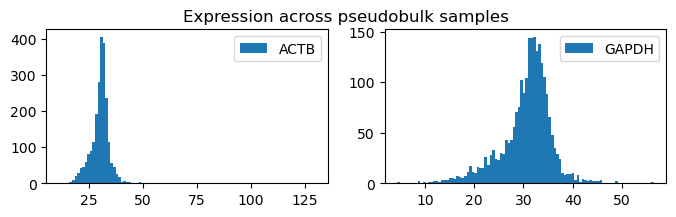

In [5]:
""" Sanity check: expression for house keeping genes are relatively stable """
fig, axes = plt.subplots(1, 2, figsize=(8,2))
axes[0].hist(pseudobulk.raw.X[:, [idx for idx, n in enumerate(pseudobulk.raw.var.index) if n.upper() == 'ACTB' ]], bins=100, label="ACTB" )
axes[1].hist(pseudobulk.raw.X[:, [idx for idx, n in enumerate(pseudobulk.raw.var.index) if n.upper() == 'GAPDH']], bins=100, label="GAPDH")
axes[0].legend()
axes[1].legend()
plt.suptitle("Expression across pseudobulk samples")
plt.show()

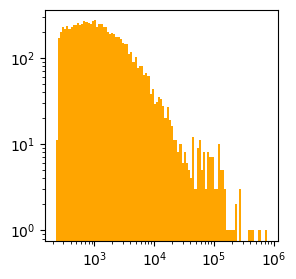

In [6]:
plt.figure(figsize=(3,3))
logbins = np.geomspace(
    pseudobulk.raw.X.sum(axis=0).min(),                    
    pseudobulk.raw.X.sum(axis=0).max(), 
    100)
plt.hist(pseudobulk.raw.X.sum(axis=0), 
         bins=logbins, 
         log=True, 
         color="orange")
plt.xscale('log')
plt.show()

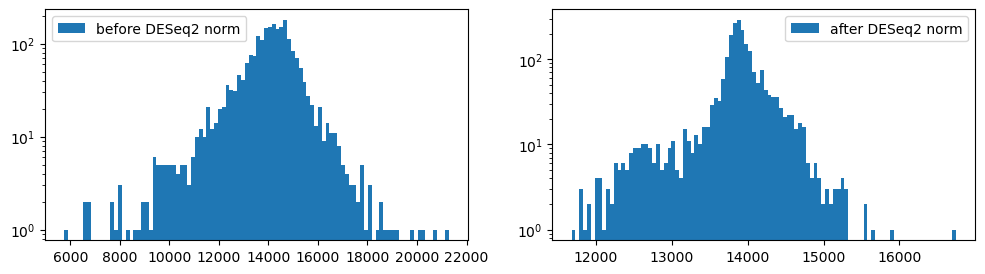

In [7]:
""" The sum of gene expression before and after normalization """
fig, axes = plt.subplots(1, 2, figsize=(12,3))
axes[0].hist(
    pseudobulk.raw.X.sum(axis=1), 
    bins=100, 
    log=True, 
    label="before DESeq2 norm")
axes[1].hist(
    pseudobulk.X.sum(axis=1), 
    bins=100, 
    log=True, 
    label="after DESeq2 norm")
axes[0].legend()
axes[1].legend()
plt.show()

,UMI_count_unfiltered,num_cells_unfiltered,num_cells_filtered,control_expr,fold_expr,pct_expr,core_control,mean_leverage_score,std_leverage_score,energy_test_p_value,...,z_gemgroup_UMI,mitopercent,TE_ratio,cnv_score_z,gene_symbol,is_tf,ensembl_id,is_control,is_control_int,perturbation
gene_transcript,,,,,,,,,,,,,,,,,,,,,
33_ABCF1_P1_ENSG00000204574,13847.319336,175,169.0,2.920531,0.112757,-0.887243,False,0.688417,0.835656,0.000100,...,0.126912,0.091834,0.013131,1.151025,ABCF1,False,ENSG00000204574,False,0,ABCF1
34_ABCF1_P2_ENSG00000204574,13891.437500,162,160.0,2.920531,1.027300,0.027300,False,0.248698,1.001973,0.332567,...,0.041530,0.108356,0.013598,0.244607,ABCF1,False,ENSG00000204574,False,0,ABCF1


(8563,) (8563,)


SpearmanrResult(correlation=0.02931209446967656, pvalue=0.006675262688005566)

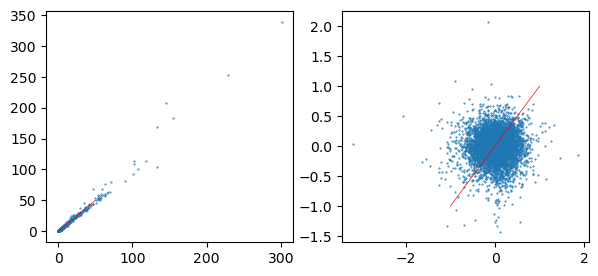

In [8]:
""" Check an exmaple (correlation at expression scale and at logFC scale) """

TFBePerturb = 'ABCF1'
display(pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].obs)
expr1 = pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].X[0,:]
expr2 = pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].X[1,:]

controlExpr  = pseudobulk[pseudobulk.obs.is_control, :].X
c1 = np.median(controlExpr.copy(), axis=0)

fig, axes = plt.subplots(1,2,figsize=(7,3))
logFC1 = np.log2(pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].X[0,:]/c1)
logFC2 = np.log2(pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].X[1,:]/c1)
validGeneEntry = np.isfinite(logFC1) & np.isfinite(logFC2)
logFC1 = logFC1[validGeneEntry]
logFC2 = logFC2[validGeneEntry]
print(logFC1.shape, logFC2.shape)
axes[0].scatter(expr1 , expr2 , s=0.2)
axes[0].plot(np.linspace(-1,50,50), np.linspace(-1,50,50), color='red', lw=0.5)
axes[1].scatter(logFC1, logFC2, s=0.2)
axes[1].plot(np.linspace(-1,1,50), np.linspace(-1,1,50), color='red', lw=0.5)
spearmanr(logFC1, logFC2)

### Consistency w/ Perturbation Direction

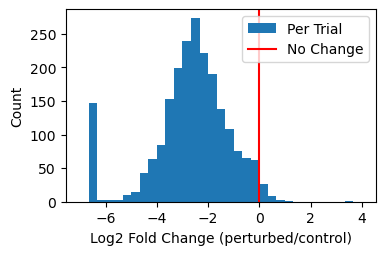

Counter({'Yes': 2096, 'No': 38, 'NA': 151})

In [9]:
# If verbose is set to True, display disconcordant trials and their controls

# Using the fold_expr field it stored in .obs 
# For perturbations where fold_expr = 0, some
# pct_expr = -1, denoting a knockout;
# others are nan, denoting lack of data or control run
fc = pseudobulk.obs.fold_expr.copy()
fc[pseudobulk.obs.pct_expr == -1] = 1e-2  # knockout
logFC = np.log2(fc)
logFC[np.isnan(logFC)] = -999             # control or no data

# Visualize the CRISPRi performance
validLogFC = logFC[logFC != -999]
rangeMin = np.floor(np.min(validLogFC))
rangeMax = np.ceil (np.max(validLogFC))
plt.figure(figsize=(4,2.5))
plt.hist(validLogFC, 
         bins=np.linspace(rangeMin, 
                          rangeMax, 
                          int((rangeMax-rangeMin)*3+1)), 
         label="Per Trial")
plt.axvline(0, 0, 1, color='red', label="No Change")
plt.xlabel("Log2 Fold Change (perturbed/control)")
plt.ylabel("Count")
plt.legend()
plt.show()

# Label knockdown outcome
status = np.full(logFC.shape[0], "NA", dtype=object)
status[(logFC <  0) & (logFC != -999)] = "Yes"
status[(logFC >= 0)] = "No"

pseudobulk.obs["consistentW/Perturbation"] = status
pseudobulk.obs["logFC"] = logFC
Counter(status)

### Consistency across replications

In [10]:
print(f"Of {pseudobulk.n_obs} observations, {len(set(pseudobulk.obs.perturbation))} unique perturbagen")

Of 2285 observations, 2058 unique perturbagen


[675 692] ABCF1 1
[1900 1930] ACIN1 2
[238 244] ADAT3 3
[764 766] AP2M1 4
[1092 1095] ARPC2 5
[1098 1099] ARPC3 6
[1792 1793] BCAR1 7
[1812 1813] BCL2L1 8
[1981 1982] BOP1 9
[27 28] C1orf109 10
[176 177] CACNB3 11
[193 194] CCDC130 12
[197 198] CCDC144NL 13
[206 207] CCND1 14
[209 210] CCNK 15
[252 253] CENPA 16
[269 270] CFDP1 17
[294 295] CKAP5 18
[326 327] COPG1 19
[334 335] COPZ1 20
[361 362] CSH2 21
[406 407] DDB1 22
[415 416] DDX19B 23
[426 427] DDX46 24
[432 433] DDX54 25
[444 445] DHODH 26
[461 462] DNAJA1 27
[480 481] DPH1 28
[499 500] DYNLRB1 29
[511 512] EEF2 30
[514 515] EGLN2 31
[544 545] EIF4G2 32
[547 548] EIF5 33
[558 559] EMC3 34
[576 577] ERVW-1 35
[578 579] ESF1 36
[581 582] ESPN 37
[638 639] FOLR3 38
[650 651] GAPDH 39
[688 689] GON4L 40
[700 701] GRB2 41
[741 742] HAUS7 42
[753 754] HIRA 43
[778 779] HMGB1 44
[786 787] HNRNPL 45
[788 789] HNRNPM 46
[816 817] IK 47
[851 852] KAT8 48
[881 882] KRT10 49
[884 885] KRT8 50
[907 908] LIN54 51
[922 923] LSM5 52
[927 928] 

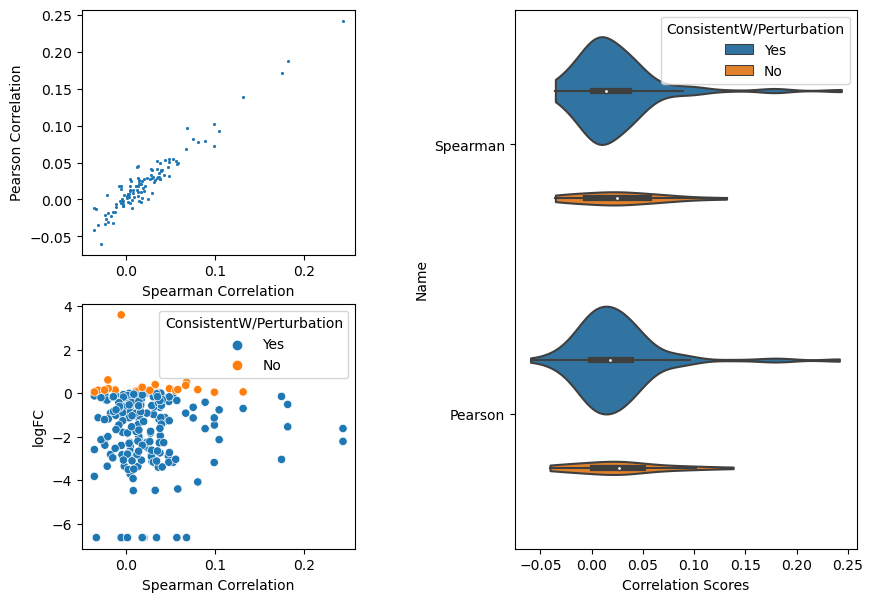

In [11]:
# !! A very small proportion of perturbations have replications
correlations = ingestion.computeCorrelation(pseudobulk, verbose=True)
pseudobulk.obs["spearmanCorr"] = correlations[0]
pseudobulk.obs[ "pearsonCorr"] = correlations[1]

### Perturbation Effect

In [12]:
"""
Downloaded from http://humantfs.ccbr.utoronto.ca/download.php """
TFList = pd.read_csv(humanTFPath, index_col=0).iloc[:, [1,3]]
TFDict = dict([tuple(i) for i in TFList.to_numpy().tolist() if i[1] == 'Yes'])

"""
Downloaded from https://epifactors.autosome.org/description """
EpiList = pd.read_csv(humanEpiPath, index_col=0).iloc[:, [0,14]]
EpiDict = dict([tuple(i) for i in EpiList.to_numpy().tolist()])

In [13]:
""" If want to look at bigness on TF only """
TFVar = [i for i,p in enumerate(pseudobulk.var.index) if p in TFDict or p in EpiDict]
pseudobulkTFOnly = pseudobulk[:, TFVar].copy()
ingestion.quantifyEffect(adata=pseudobulkTFOnly, 
                         fname=perturbEffectTFOnlyPath, 
                         group=None, 
                         diffExprFC=False, 
                         prefix="TFOnly", 
                         withDEG=False, 
                         withMI=False)

530
0 AAAS -999.0 0.13456110656261444 0.10397835820913315 6.1386003494262695 -999.0
1 AAMP -999.0 0.2213342934846878 0.16478803753852844 10.235669136047363 -999.0
2 AARS -999.0 0.46132028102874756 0.3571583926677704 21.333864212036133 -999.0
3 AARS2 -999.0 0.15181773900985718 0.107354074716568 7.284783840179443 -999.0
4 AASDHPPT -999.0 0.28422534465789795 0.19920223951339722 14.099617958068848 -999.0
5 AATF -999.0 0.20342175662517548 0.16208186745643616 9.104609489440918 -999.0
6 ABCB10 -999.0 0.2933538258075714 0.22605197131633759 13.74518871307373 -999.0
7 ABCB7 -999.0 0.15658296644687653 0.12076319754123688 7.263064384460449 -999.0
8 ABCE1 -999.0 0.2274036556482315 0.1776183843612671 10.474090576171875 -999.0
9 ABCF1 -999.0 0.12935924530029297 0.09833702445030212 6.0276055335998535 -999.0
10 ABCG1 -999.0 0.1659715473651886 0.12089837342500687 7.88226842880249 -999.0
11 ABHD11 -999.0 0.2996154725551605 0.19828706979751587 15.576883316040039 -999.0
12 ABHD17A -999.0 0.1970013380050659

In [14]:
ingestion.quantifyEffect(adata=pseudobulk, 
                         fname=perturbEffectFullTranscriptomePath, 
                         group=None,
                         diffExprFC=False, 
                         prefix="",
                         withDEG=False, 
                         withMI=False)

listOfMetrics = ["DEG", "MI", "logFCMean", "logFCNorm2", "logFCMedian"]
for m in listOfMetrics:
    pseudobulk.obs[f"TFOnly{m}"] = pseudobulkTFOnly.obs[f"TFOnly{m}"]

3998
0 AAAS -999.0 0.13233792781829834 0.09566035866737366 17.212358474731445 -999.0
1 AAMP -999.0 0.22608628869056702 0.17091140151023865 28.46921157836914 -999.0
2 AARS -999.0 0.484692245721817 0.37304943799972534 59.822288513183594 -999.0
3 AARS2 -999.0 0.1463400274515152 0.10422664880752563 19.19237518310547 -999.0
4 AASDHPPT -999.0 0.27817288041114807 0.19402983784675598 37.112911224365234 -999.0
5 AATF -999.0 0.2094072848558426 0.16607801616191864 25.60041618347168 -999.0
6 ABCB10 -999.0 0.285944402217865 0.20923101902008057 36.68598937988281 -999.0
7 ABCB7 -999.0 0.15434212982654572 0.11389760673046112 19.807178497314453 -999.0
8 ABCE1 -999.0 0.2452913075685501 0.19382670521736145 29.961788177490234 -999.0
9 ABCF1 -999.0 0.13173343241214752 0.09847686439752579 16.58073616027832 -999.0
10 ABCG1 -999.0 0.16663745045661926 0.12068860232830048 21.464096069335938 -999.0
11 ABHD11 -999.0 0.2859790027141571 0.19607946276664734 38.49585723876953 -999.0
12 ABHD17A -999.0 0.19256506860256

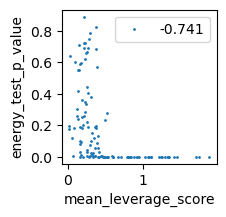

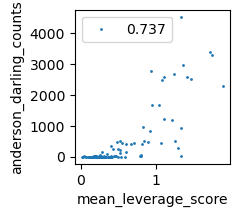

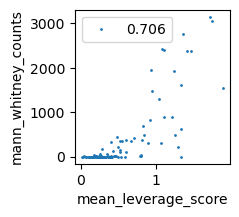

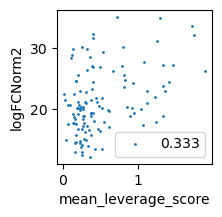

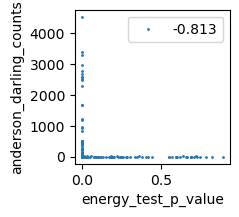

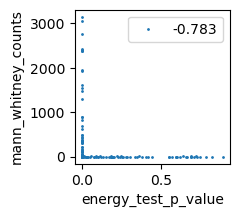

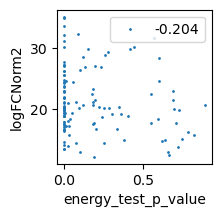

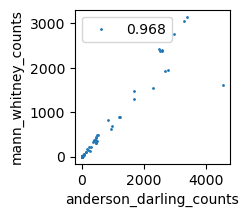

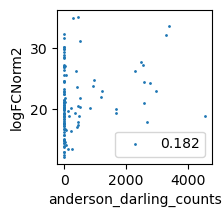

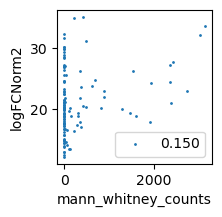

In [15]:
metricOfInterest = ["mean_leverage_score", 'energy_test_p_value', 'anderson_darling_counts', 
                    'mann_whitney_counts', 'logFCNorm2']
ingestion.checkPerturbationEffectMetricCorrelation(pseudobulk, metrics=metricOfInterest)

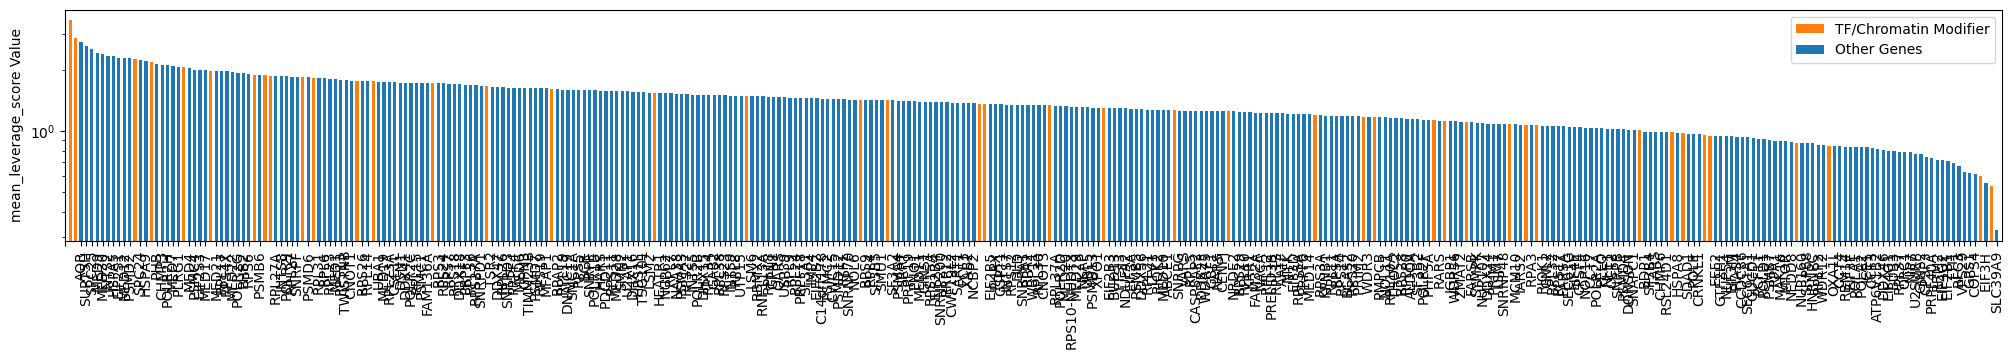

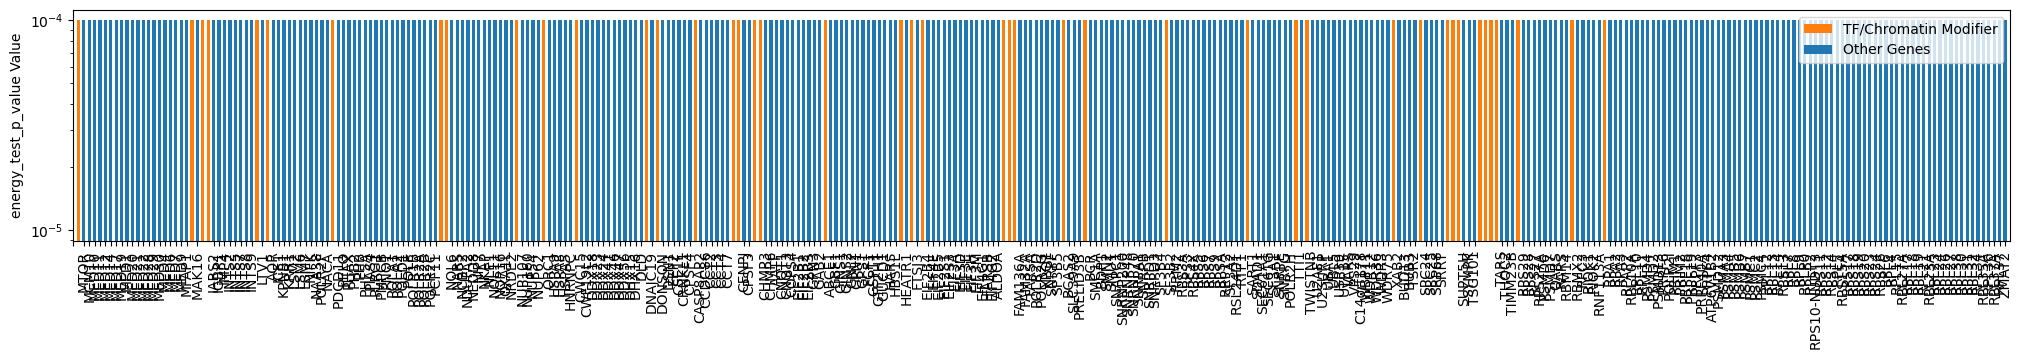

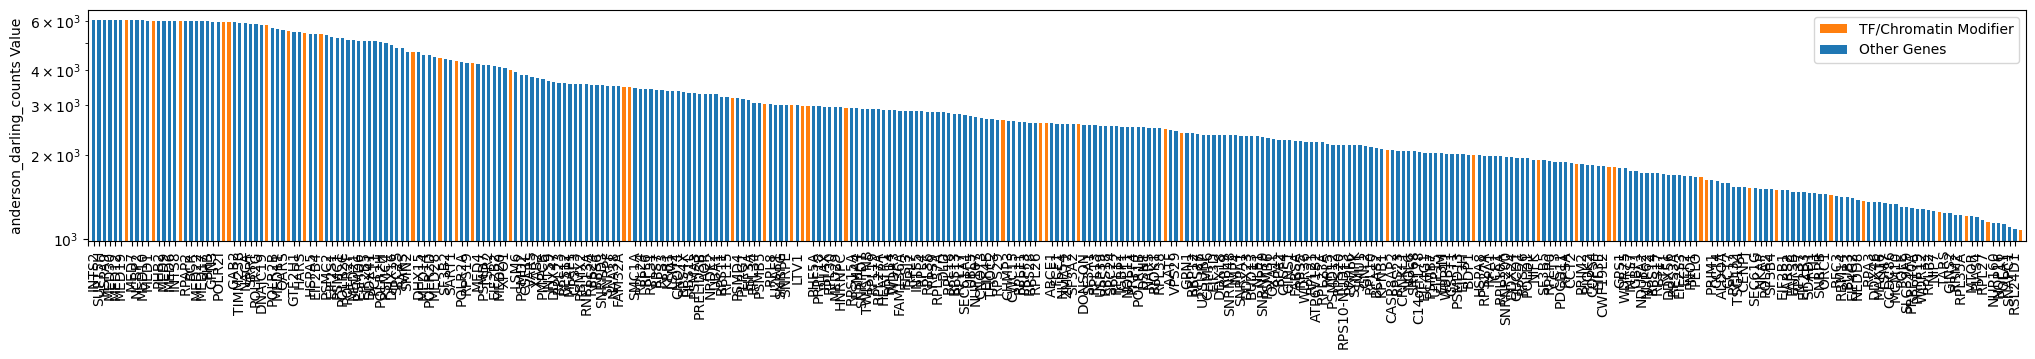

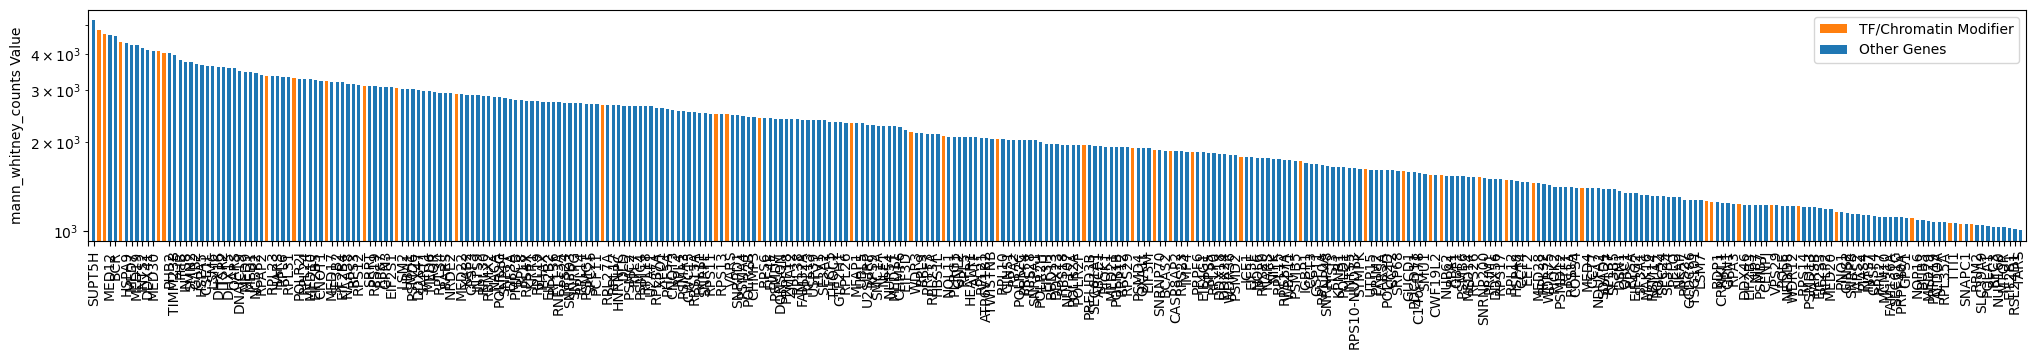

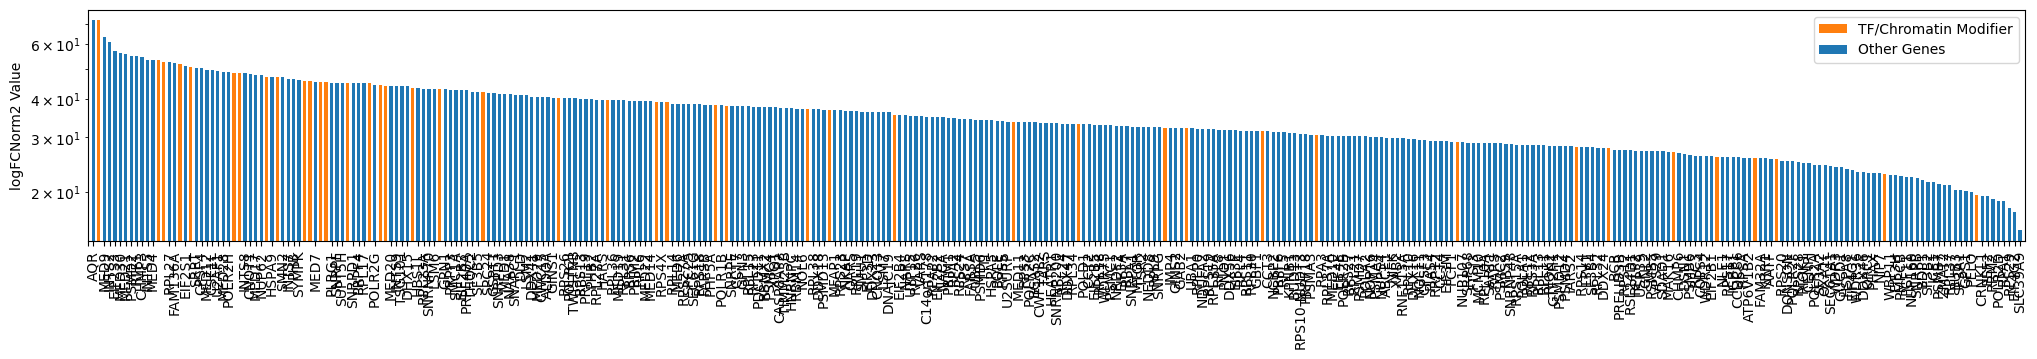

In [16]:
# Unable to look at everything
# Thus, look only at perturbation that results in more than 1000 DEGs
ingestion.visualizePerturbationEffect(
    pseudobulk[pseudobulk.obs.mann_whitney_counts > 1000], 
    metrics=metricOfInterest, 
    TFDict=TFDict, 
    EpiDict=EpiDict
)

In [17]:
for idx, p in enumerate(sorted(set([(i,j) for i,j in pseudobulk.obs[['perturbation', 'logFCNorm2']].to_numpy()]), key=lambda x: x[1])):
    print(idx, p)

0 ('non-targeting', -999.0)
1 ('RPL3', 8.15290641784668)
2 ('KIF11', 8.567115783691406)
3 ('NUP205', 10.067314147949219)
4 ('ANAPC15', 11.745182037353516)
5 ('BUB1', 11.829339981079102)
6 ('SNX15', 12.060081481933594)
7 ('ESPN', 12.340507507324219)
8 ('CADM4', 12.745433807373047)
9 ('PSTK', 12.830963134765625)
10 ('PRODH', 12.854975700378418)
11 ('PSMG3', 13.285922050476074)
12 ('PPP2R1A', 13.312948226928711)
13 ('KRT8', 13.578807830810547)
14 ('SLC1A5', 13.87596607208252)
15 ('SRSF11', 13.997671127319336)
16 ('WDR4', 14.117524147033691)
17 ('LIMS1', 14.220775604248047)
18 ('EGLN2', 14.296842575073242)
19 ('CACNB3', 14.362519264221191)
20 ('DPH1', 14.485630989074707)
21 ('RAB4A', 14.652935028076172)
22 ('PCID2', 14.700499534606934)
23 ('CDC27', 14.781542778015137)
24 ('HIRA', 14.871794700622559)
25 ('DDX19B', 14.884722709655762)
26 ('CKAP5', 14.98568058013916)
27 ('ASF1B', 14.99586296081543)
28 ('TEAD3', 15.0193510055542)
29 ('SLC39A9', 15.02474594116211)
30 ('CDK11A', 15.0453062057495

2285 number of points are plotted


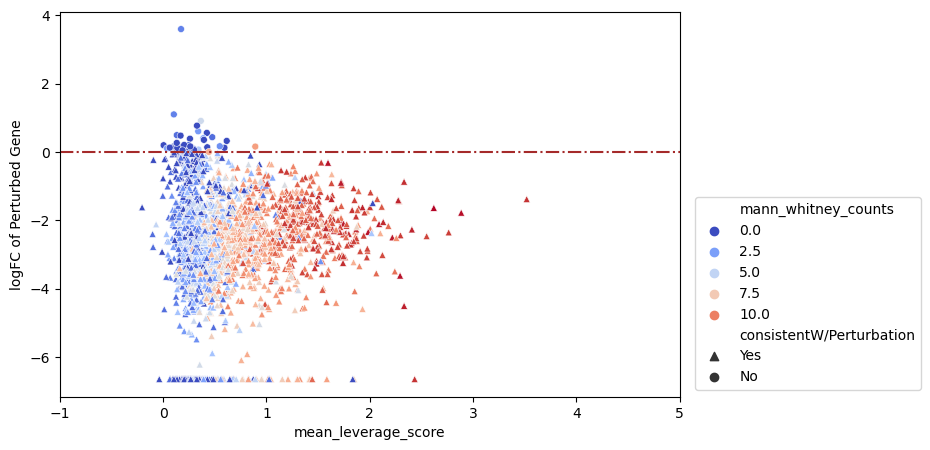

In [18]:
temp = pseudobulk.copy()

""" If you wish to see the magnitude of perturbation effect more clearer,
    i.e. a smoother gradient of the color shift, feel free to uncomment
    the line below, which takes the log of the mann_whitney_counts """
temp.obs['mann_whitney_counts'] = np.log2(temp.obs['mann_whitney_counts']+1)

ingestion.visualizePerturbationMetadata(temp, 
                                        x="mean_leverage_score", 
                                        y="logFC", 
                                        style="consistentW/Perturbation", 
                                        hue="mann_whitney_counts", 
                                        markers=['^', 'o'],
                                        xlim=[-1, 5], 
                                        s=25)

2134


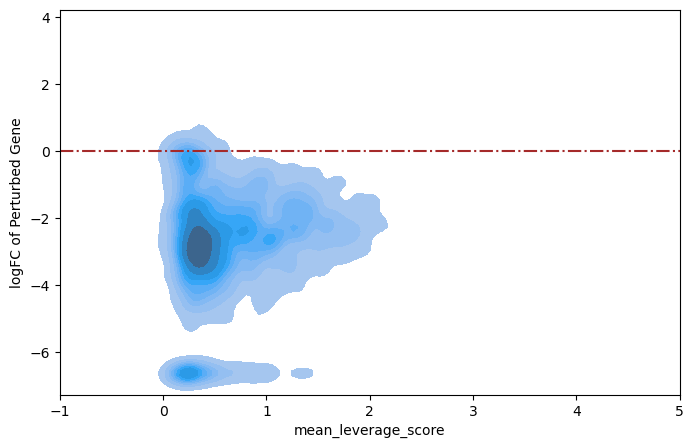

In [19]:
x = "mean_leverage_score"
y = "logFC"
style = "consistentW/Perturbation"
hue = "mann_whitney_counts"
markers = ['^', 'o']
xlim = [-1, 5]
s = 25
adata = pseudobulk

validMat = (adata.obs[x] != -999) & (adata.obs[y] != -999) & (~adata.obs.is_control)
print(sum(validMat))
plt.figure(figsize=(8, 5))


g =sns.kdeplot(data=adata.obs[validMat], 
               x=x,
               y=y,
               palette=sns.color_palette("coolwarm", as_cmap=True), 
               fill=True, 
               gridsize=100, 
               bw_adjust=0.5)
plt.axhline(0, 0, 1, linestyle='-.', color='brown')
plt.ylabel(f"{y} of Perturbed Gene")
plt.xlim(xlim)
plt.show()

### Basic EDA

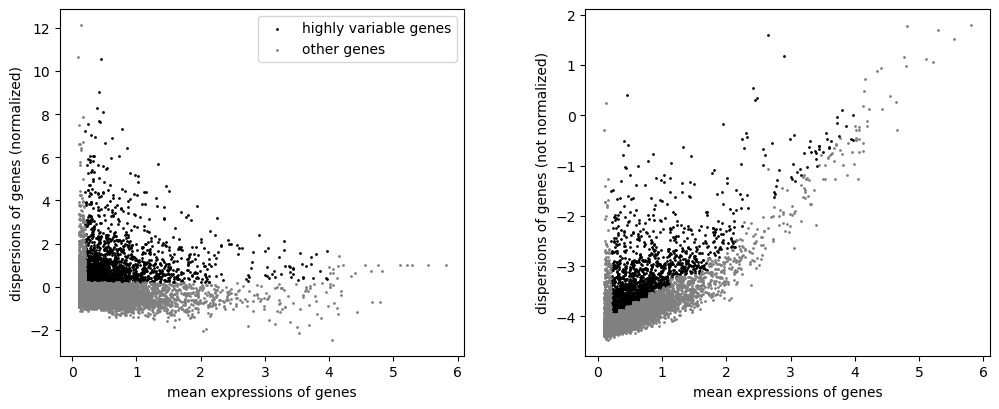

In [20]:
sc.pp.log1p(pseudobulk)
sc.pp.highly_variable_genes(pseudobulk, min_mean=0.2, max_mean=4, min_disp=0.2, n_bins=50)
sc.pl.highly_variable_genes(pseudobulk)
with warnings.catch_warnings():
    sc.tl.pca(pseudobulk, n_comps=100)
sc.pp.neighbors(pseudobulk)
sc.tl.umap(pseudobulk)
clusterResolutions = []
sc.tl.leiden(pseudobulk)

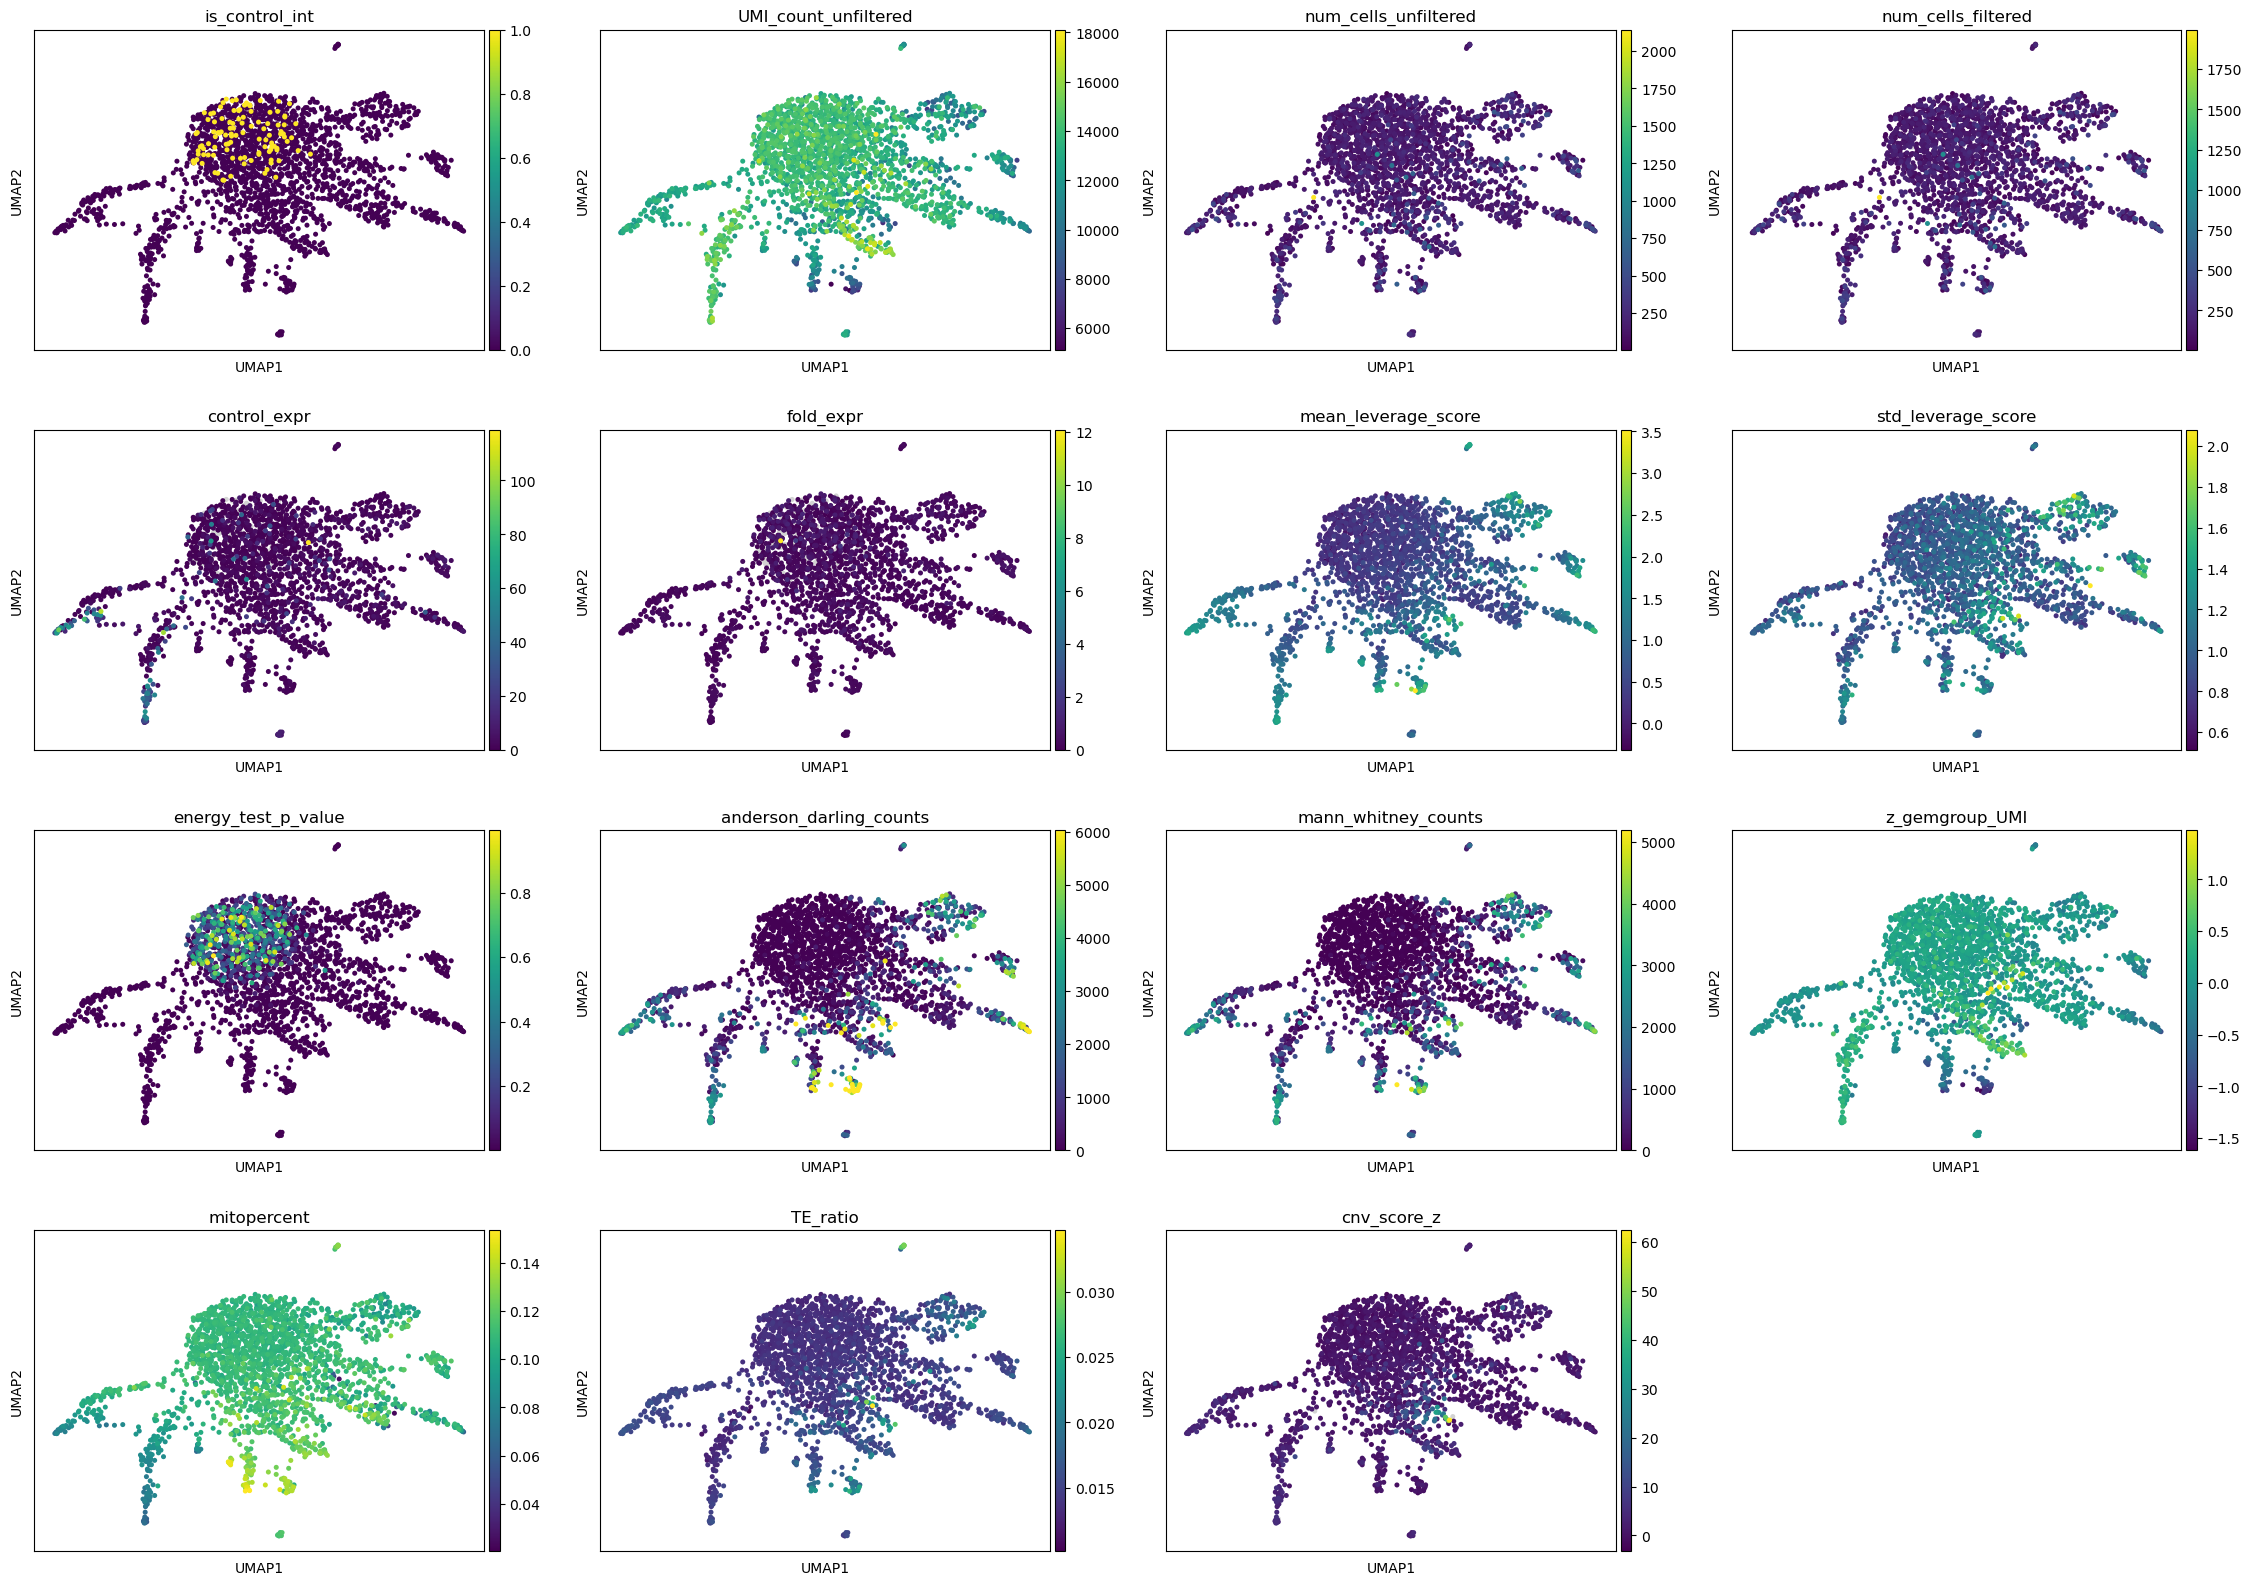

In [21]:
plt.rcParams['figure.figsize'] = [6, 4.5]
sc.pl.umap(pseudobulk, color = [
    "is_control_int",
    'UMI_count_unfiltered', 'num_cells_unfiltered', 'num_cells_filtered',
       'control_expr', 'fold_expr', 
       'mean_leverage_score', 'std_leverage_score', 'energy_test_p_value',
       'anderson_darling_counts', 'mann_whitney_counts', 'z_gemgroup_UMI',
       'mitopercent', 'TE_ratio', 'cnv_score_z',
])
# Will ask CO to use only one cluster.
# Requires setting certain other undocumented aspects of object state. :(
pseudobulk.obs["fake_cluster"]="all_one_cluster"
pseudobulk.obs.fake_cluster = pseudobulk.obs.fake_cluster.astype("category")
pseudobulk.uns["fake_cluster_colors"] = ['#1f77b4']

### Data reduction/QC

With only 64GB of RAM, I have been unable to make whole-transcriptome predictions with CellOracle. A data reduction step is necessary where only highly variable genes are included. We also keep all genes that are perturbed, whether or not they appear highly variable -- unless they are unavailable in the first place. 

In [22]:
""" Keep everything that gets correctly knockdown & control & perturbed but not measured """

pseudobulk = pseudobulk[(pseudobulk.obs.logFC < 0) | (pseudobulk.obs.logFC == -999),:].copy()

In [23]:
perturbed_genes = set(list(pseudobulk.obs['perturbation'].unique())).difference(controls)
perturbed_and_measured_genes = perturbed_genes.intersection(pseudobulk.var.index)
perturbed_but_not_measured_genes = perturbed_genes.difference(pseudobulk.var.index)
genes_keep = pseudobulk.var.index[pseudobulk.var['highly_variable']]
genes_keep = set(genes_keep).union(perturbed_and_measured_genes)
pseudobulk_orig = pseudobulk.copy()
print("This many genes were perturbed:")
print(len(perturbed_genes))
print("These genes were perturbed but not measured:")
print(len(perturbed_but_not_measured_genes))
print("This many variable genes will be kept and used by CO:")
print(len(genes_keep))

This many genes were perturbed:
2044
These genes were perturbed but not measured:
210
This many variable genes will be kept and used by CO:
3272


In [24]:
# final form, ready to save
pseudobulk = pseudobulk_orig[:,list(genes_keep)]
pseudobulk.uns["perturbed_and_measured_genes"]     = list(perturbed_and_measured_genes)
pseudobulk.uns["perturbed_but_not_measured_genes"] = list(perturbed_but_not_measured_genes)
pseudobulk = ingestion.describe_perturbation_effect(pseudobulk, "knockdown")

In [25]:
os.makedirs(f"perturbations/{dataset_name}", exist_ok = True)
pseudobulk.write_h5ad(f"perturbations/{dataset_name}/test.h5ad")